# RNN例子2
使用PyTorch搭建RNN模型，完成简单的文本分类任务。本次作业的选做题难度较大，仅供有自然语言处理基础且时间充裕的同学完成。


## 一、数据处理

首先导入常用软件包。

In [2]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt 
import os
import glob
from sklearn.model_selection import train_test_split
import spacy
import numpy as np

from torchtext.legacy import data
from tqdm import tqdm

ModuleNotFoundError: No module named 'torchtext.legacy'

本次作业使用的数据为torchtext.data中的AG_NEWS，每一行代表一个样本，三列数据分别代表：“类别”，“标题”，“正文”。该数据集中的类别有四种：“World”, “Sports”, “Business”, “Sci/Tech”，分别用数字1-4表示。

因为原始数据集较大，截取了其中一部分作为训练集和测试集，train.csv中包含6600条数据，test.csv中包含1000条数据。

使用torchtext完成数据的加载，主要使用以下三个组件：

1. Field : 主要包含以下数据预处理的配置信息，比如指定分词方法，是否转成小写，起始字符，结束字符，补全字符以及词典等等

2. Dataset : 继承自pytorch的Dataset，用于加载数据，提供了TabularDataset可以指点路径，格式，Field信息就可以方便的完成数据加载。同时torchtext还提供预先构建的常用数据集的Dataset对象，可以直接加载使用，splits方法可以同时加载训练集，验证集和测试集。

3. Iterator : 主要是数据输出的模型的迭代器，可以支持batch定制

如果在使用torchtext的过程中出现报错的情况，一种可能是由于版本问题，相关的类被移动到torchtext.legacy当中

In [19]:
TEXT = data.Field(sequential=True, batch_first=True, include_lengths=True)
TITLE = data.Field(sequential=True, batch_first=True, include_lengths=True)
LABEL = data.Field(sequential=False, batch_first=True, use_vocab=False)

fields = [('label', LABEL), ('title', TITLE), ('text',TEXT)]  # 通过定义fields可以方便地读取数据，这里第一列为label，第三列为需要分类的text，标题暂时不需要

train_data = data.TabularDataset(path='train.csv', format='csv', fields=fields, skip_header=False)
test_data = data.TabularDataset(path='test.csv', format='csv', fields=fields, skip_header=False)
#print preprocessed text
print(vars(train_data.examples[0]))
print(vars(test_data.examples[0]))

{'label': '3', 'title': ['Fears', 'for', 'T', 'N', 'pension', 'after', 'talks'], 'text': ['Unions', 'representing', 'workers', 'at', 'Turner', 'Newall', 'say', 'they', 'are', "'disappointed'", 'after', 'talks', 'with', 'stricken', 'parent', 'firm', 'Federal', 'Mogul.']}
{'label': '2', 'title': ['Six', 'players', 'suspended', 'for', 'one', 'game'], 'text': ['Six', 'players', 'from', 'both', 'Clemson', 'and', 'South', 'Carolina', 'will', 'be', 'suspended', 'for', 'one', 'game', 'next', 'season', 'for', 'their', 'participation', 'in', 'a', 'brawl', 'near', 'the', 'end', 'of', 'the', 'rivalry', 'game', 'November', '20th.']}


torchtext提供了构建词表的功能：我们使用50维的预训练词向量，建立词典、索引以及对应的词向量映射关系。

下载后的预训练词向量会默认存储在“.vector_cache”文件夹中。

In [23]:
#initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors="glove.6B.50d")  # 去除低频词，使用50维的预训练词向量
TITLE.build_vocab(train_data, min_freq=3, vectors="glove.6B.50d")
LABEL.build_vocab(train_data)



In [24]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:", len(TEXT.vocab))
print("Size of TITLE vocabulary:", len(TITLE.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:", len(LABEL.vocab))  # 这里长度为5是因为build_vocabulary默认会添加一个<unk> token

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  # tuple中第一个元素为单词，第二个元素为对应的索引

#Word dictionary
#print(TEXT.vocab.stoi)   # stoi可以将单词转换为数字索引

Size of TEXT vocabulary: 8463
Size of TITLE vocabulary: 3273
Size of LABEL vocabulary: 5
[('the', 9539), ('a', 5240), ('to', 5228), ('of', 4857), ('in', 4099), ('and', 3620), ('on', 2477), ('-', 2062), ('for', 2026), ('that', 1500)]


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 有条件的同学可以使用gpu加速训练

device 

device(type='cpu')

In [26]:
batch_size = 64

# 划分之后的数据集，每个batch中有64个样本
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size=batch_size,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device)

### 词向量小练习

glove.6B.50d.txt中每一行表示：单词 50维词向量

gensim支持word2vec格式，因此需要先转换glove格式的词向量文件

In [27]:
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# 格式转换
glove_input_file = '.vector_cache/glove.6B.50d.txt'
word2vec_output_file = '.vector_cache/glove.6B.50d.word2vec.txt'
(count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)

# 加载词向量
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-27-ba80ecbaec4f>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  (count, dimensions) = glove2word2vec(glove_input_file, word2vec_output_file)


词向量的加减可以得到有趣的结果，一个著名例子是公式：king - man + woman

In [28]:
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man']) 
print(result)

[('queen', 0.8523604273796082), ('throne', 0.7664334177970886), ('prince', 0.759214460849762), ('daughter', 0.7473882436752319), ('elizabeth', 0.7460219860076904), ('princess', 0.7424570322036743), ('kingdom', 0.7337411642074585), ('monarch', 0.721449077129364), ('eldest', 0.7184861898422241), ('widow', 0.7099431157112122)]


**请自由尝试几个其他的词向量加减例子**

In [3]:
# TODO



[('japan', 0.7802004218101501), ('china', 0.7683160901069641), ('domestic', 0.7585546374320984), ('asian', 0.7354557514190674), ('asia', 0.7289562821388245), ('u.s.', 0.7251277565956116), ('taiwan', 0.7245966792106628), ('states', 0.721280574798584), ('kong', 0.7186021208763123), ('biggest', 0.7148484587669373)]
[('hospital', 0.6625596284866333), ('surgeon', 0.6420620679855347), ('dentist', 0.6127005815505981), ('sick', 0.6047527194023132), ('surgery', 0.5822544693946838), ('pregnant', 0.5819782018661499), ('veterinarian', 0.5811264514923096), ('sleeping', 0.5784093737602234), ('ambulance', 0.5779232382774353), ('baby', 0.5739707350730896)]


**请通过合适的方法将词向量降至2或3维，在空间坐标中显示出下列单词的位置，进行词向量可视化**

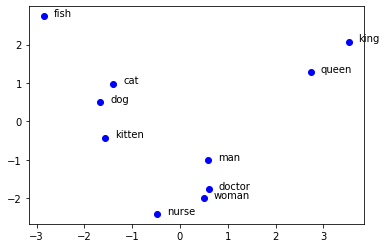

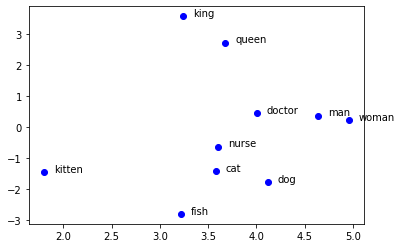

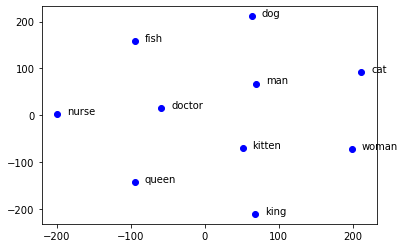

In [9]:
words = ["cat", "dog", "fish", "kitten", "man", "woman",
         "king", "queen", "doctor", "nurse"]

# TODO

# PCA降维
from sklearn.decomposition import PCA
vec = glove_model[words]
vec_pca = PCA(n_components=2).fit_transform(vec)
fig, ax = plt.subplots()
for i in range(len(words)):
    ax.scatter(vec_pca[i][0], vec_pca[i][1], color='blue')
    ax.annotate(words[i], xy=(vec_pca[i,0], vec_pca[i,1]), xytext=(10, 0), textcoords='offset points', fontsize=10)
plt.show()

# SVD降维
from sklearn.decomposition import TruncatedSVD
vec = glove_model[words]
vec_pca = TruncatedSVD(n_components=2).fit_transform(vec)
fig, ax = plt.subplots()
for i in range(len(words)):
    ax.scatter(vec_pca[i][0], vec_pca[i][1], color='blue')
    ax.annotate(words[i], xy=(vec_pca[i,0], vec_pca[i,1]), xytext=(10, 0), textcoords='offset points', fontsize=10)
plt.show()

# TSNE降维
from sklearn.manifold import TSNE
vec = glove_model[words]
vec_pca = TSNE(n_components=2).fit_transform(vec)
fig, ax = plt.subplots()
for i in range(len(words)):
    ax.scatter(vec_pca[i][0], vec_pca[i][1], color='blue')
    ax.annotate(words[i], xy=(vec_pca[i,0], vec_pca[i,1]), xytext=(10, 0), textcoords='offset points', fontsize=10)
plt.show()

## 二、RNN模型搭建

这里参考课件上的代码搭建了一个简单的RNN模型

1. 每次读取一个单词，因此RNN的输入维度为50（即词向量的维度）再加上hidden_size
2. 最终的输出维度为4（对应四个类别）
3. 初始隐状态可以用零向量

有需要的话可以自由修改

In [29]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        #self.i2o = nn.Linear(embedding_dim + hidden_size, output_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        #output = self.i2o(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  # 初始化全0的隐状态向量

## 三、模型训练

In [33]:
def train_step(model, batch_data, optimizer, criterion):
    optimizer.zero_grad()
    total_loss = 0
    total_acc = 0

    # 载入数据
    texts, text_lengths = batch_data.text  # texts当中存储的是单词的数字索引
    labels = batch_data.label
    titles = batch_data.title    
    #print(labels)
    #print(texts, text_lengths)
    #print(len(text_lengths))
    
    for text, label, title in zip(texts, labels, titles):
        hidden = model.init_hidden().to(device)  # 创建一个初始隐状态
        # 每次输入batch中的一个样本
        
        for i in range(len(text)):
            embedding = TEXT.vocab.vectors[text[i]]  # 根据text中的数字索引获得对应的词向量
            embedding = embedding.to(device)
            # print(embedding)
            output, hidden = model(embedding.reshape(1, -1), hidden)  # 变换词向量的维度，使其能和hidden tensor拼接起来
        target = (label - 1).unsqueeze(0)  # 原始label是1~4，减1之后对应下标0~3
        loss = criterion(output, target)   # 计算loss
        loss.backward(retain_graph=True)
        
        total_loss += loss.item()
        
        if output.argmax(1) == label - 1:  # 判断模型预测的概率最大的类是否正确
            total_acc += 1
    
    optimizer.step()
    
    return total_loss / len(batch_data), total_acc / len(batch_data)

在训练过程中，我们希望能够保存效果最好的模型，使用save()和load()函数可以实现模型的保存和加载。

参考文档：https://pytorch.org/tutorials/beginner/saving_loading_models.html

**请实现：保存训练过程中loss最小的模型**

考虑到训练阶段运行时间可能比较长，同学们可以自行选择合适的epoch数。本次作业旨在让大家熟悉基本模型结构，模型最终的表现效果不会成为评分指标。

In [34]:
def train(model, iterator, lr=0.01, num_epoch=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_arr = []
    epoch_acc = 0
    
    # set the model in training phase
    model.train()
    
    min_loss = 1e9
    for epoch in tqdm(range(num_epoch)):
        mean_acc = []
        mean_loss = []
        for i, batch_data in enumerate(iterator):
            batch_loss, batch_acc = train_step(model, batch_data, optimizer, criterion)
            loss_arr.append(batch_loss)
            mean_loss.append(batch_loss)
            if (i + 1) % 10 == 0:
                print("Iteration number:", i + 1,'Loss:', batch_loss, "Acc:", batch_acc)
            mean_acc.append(batch_acc)
        print("Epoch Acc:", np.mean(mean_acc), "Epoch loss", np.mean(mean_loss))
        
        # TODO: 保存loss最小的模型
        if np.mean(mean_loss) < min_loss:
            min_loss = np.mean(mean_loss)
            torch.save(model, 'best.pt')
            # torch.save(model.state_dict(), 'best.pt')
        
    
    # 绘制loss曲线
    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Iteration number: 10 Loss: 0.04387255758047104 Acc: 0.0
Iteration number: 20 Loss: 0.04366613179445267 Acc: 0.0
Iteration number: 30 Loss: 0.038737738505005836 Acc: 0.015625
Iteration number: 40 Loss: 0.04885859228670597 Acc: 0.0
Iteration number: 50 Loss: 0.03759835101664066 Acc: 0.015625
Iteration number: 60 Loss: 0.03398815169930458 Acc: 0.03125
Iteration number: 70 Loss: 0.04505119286477566 Acc: 0.0
Iteration number: 80 Loss: 0.048263970762491226 Acc: 0.0
Iteration number: 90 Loss: 0.03583473525941372 Acc: 0.015625
Iteration number: 100 Loss: 0.02639049105346203 Acc: 0.03125
Epoch Acc: 0.009314903846153846 Epoch loss 


 10%|████████▎                                                                          | 1/10 [00:01<00:12,  1.37s/it]

0.04566940328536125
Iteration number: 10 Loss: 0.046844881027936935 Acc: 0.015625
Iteration number: 20 Loss: 0.041101573035120964 Acc: 0.015625
Iteration number: 30 Loss: 0.03544234484434128 Acc: 0.03125
Iteration number: 40 Loss: 0.0342024527490139 Acc: 0.015625
Iteration number: 50 Loss: 0.027332902420312166 Acc: 0.015625
Iteration number: 60 Loss: 0.03467985149472952 Acc: 0.015625
Iteration number: 70 Loss: 0.046323904767632484 Acc: 0.015625
Iteration number: 80 Loss: 0.03384748473763466 Acc: 0.015625
Iteration number: 90 Loss: 0.04891413636505604 Acc: 0.015625



 20%|████████████████▌                                                                  | 2/10 [00:02<00:10,  1.35s/it]

Iteration number: 100 Loss: 0.030247762799263 Acc: 0.015625
Epoch Acc: 0.014723557692307692 Epoch loss 0.04376455122613921
Iteration number: 10 Loss: 0.029039332643151283 Acc: 0.015625
Iteration number: 20 Loss: 0.028838735073804855 Acc: 0.015625
Iteration number: 30 Loss: 0.05137506127357483 Acc: 0.0
Iteration number: 40 Loss: 0.04272022843360901 Acc: 0.0
Iteration number: 50 Loss: 0.05175697896629572 Acc: 0.015625
Iteration number: 60 Loss: 0.04798996075987816 Acc: 0.0
Iteration number: 70 Loss: 0.04652024619281292 Acc: 0.0
Iteration number: 80 Loss: 0.03333781659603119 Acc: 0.015625
Iteration number: 90 Loss: 0.03951288387179375 Acc: 0.0
Iteration number: 100 Loss: 0.039192214608192444 Acc: 0.0



 30%|████████████████████████▉                                                          | 3/10 [00:04<00:09,  1.38s/it]

Epoch Acc: 0.013070913461538462 Epoch loss 0.04306403194809368
Iteration number: 10 Loss: 0.053316228091716766 Acc: 0.0
Iteration number: 20 Loss: 0.06259190663695335 Acc: 0.0
Iteration number: 30 Loss: 0.013124437537044287 Acc: 0.03125
Iteration number: 40 Loss: 0.0178776104003191 Acc: 0.03125
Iteration number: 50 Loss: 0.030964010395109653 Acc: 0.015625
Iteration number: 60 Loss: 0.04096990078687668 Acc: 0.0
Iteration number: 70 Loss: 0.03902390878647566 Acc: 0.015625
Iteration number: 80 Loss: 0.04034937918186188 Acc: 0.015625
Iteration number: 90 Loss: 0.04851875081658363 Acc: 0.0



 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:08,  1.38s/it]

Iteration number: 100 Loss: 0.04484296217560768 Acc: 0.0
Epoch Acc: 0.012319711538461538 Epoch loss 0.04098081335066057
Iteration number: 10 Loss: 0.03724759630858898 Acc: 0.015625
Iteration number: 20 Loss: 0.042373744770884514 Acc: 0.015625
Iteration number: 30 Loss: 0.04147172160446644 Acc: 0.0
Iteration number: 40 Loss: 0.03195241745561361 Acc: 0.015625
Iteration number: 50 Loss: 0.04612627997994423 Acc: 0.0
Iteration number: 60 Loss: 0.03500481881201267 Acc: 0.015625
Iteration number: 70 Loss: 0.03604310005903244 Acc: 0.03125
Iteration number: 80 Loss: 0.008093115058727562 Acc: 0.03125
Iteration number: 90 Loss: 0.025212913285940886 Acc: 0.03125
Iteration number: 100 Loss: 0.02999995881691575 Acc: 0.015625



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:06,  1.38s/it]

Epoch Acc: 0.018329326923076924 Epoch loss 0.03869066988520969
Iteration number: 10 Loss: 0.017750555998645723 Acc: 0.03125
Iteration number: 20 Loss: 0.0019797070999629796 Acc: 0.03125
Iteration number: 30 Loss: 0.035072389990091324 Acc: 0.015625
Iteration number: 40 Loss: 0.031143423169851303 Acc: 0.015625
Iteration number: 50 Loss: 0.025811084546148777 Acc: 0.015625
Iteration number: 60 Loss: 0.036287023685872555 Acc: 0.015625
Iteration number: 70 Loss: 0.0381858479231596 Acc: 0.015625
Iteration number: 80 Loss: 0.03519196715205908 Acc: 0.0
Iteration number: 90 Loss: 0.05195692367851734 Acc: 0.0



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.37s/it]

Iteration number: 100 Loss: 0.020240797195583582 Acc: 0.015625
Epoch Acc: 0.014723557692307692 Epoch loss 0.0350898236159852
Iteration number: 10 Loss: 0.005096597480587661 Acc: 0.03125
Iteration number: 20 Loss: 0.052426936104893684 Acc: 0.0
Iteration number: 30 Loss: 0.03525853622704744 Acc: 0.015625
Iteration number: 40 Loss: 0.047583818435668945 Acc: 0.0
Iteration number: 50 Loss: 0.020569838816300035 Acc: 0.015625
Iteration number: 60 Loss: 0.020578829338774085 Acc: 0.015625
Iteration number: 70 Loss: 0.04690556414425373 Acc: 0.0
Iteration number: 80 Loss: 0.02676716446876526 Acc: 0.03125
Iteration number: 90 Loss: 0.03389227204024792 Acc: 0.015625



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:04,  1.36s/it]

Iteration number: 100 Loss: 0.05086190812289715 Acc: 0.0
Epoch Acc: 0.018629807692307692 Epoch loss 0.03488186408293796
Iteration number: 10 Loss: 0.02796877548098564 Acc: 0.015625
Iteration number: 20 Loss: 0.04176526807714254 Acc: 0.015625
Iteration number: 30 Loss: 0.0007469833944924176 Acc: 0.03125
Iteration number: 40 Loss: 0.021324344926142658 Acc: 0.015625
Iteration number: 50 Loss: 0.15221666544675827 Acc: 0.0
Iteration number: 60 Loss: 0.04542853496968746 Acc: 0.0
Iteration number: 70 Loss: 0.027060010470449924 Acc: 0.03125
Iteration number: 80 Loss: 0.012140627368353307 Acc: 0.03125



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:10<00:02,  1.37s/it]

Iteration number: 90 Loss: 0.04028541222214699 Acc: 0.0
Iteration number: 100 Loss: 0.033707182854413986 Acc: 0.015625
Epoch Acc: 0.018028846153846152 Epoch loss 0.03550832775729873
Iteration number: 10 Loss: 0.039710067212581635 Acc: 0.0
Iteration number: 20 Loss: 0.05932071432471275 Acc: 0.015625
Iteration number: 30 Loss: 0.03129049204289913 Acc: 0.015625
Iteration number: 40 Loss: 0.026578410528600216 Acc: 0.015625
Iteration number: 50 Loss: 0.043804594315588474 Acc: 0.015625
Iteration number: 60 Loss: 0.038539002649486065 Acc: 0.015625
Iteration number: 70 Loss: 0.02438630536198616 Acc: 0.03125
Iteration number: 80 Loss: 0.02648872137069702 Acc: 0.03125
Iteration number: 90 Loss: 0.027384410612285137 Acc: 0.015625
Iteration number: 100 Loss: 0.04097380489110947 Acc: 0.0



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:12<00:01,  1.37s/it]

Epoch Acc: 0.01697716346153846 Epoch loss 0.04321660874792052
Iteration number: 10 Loss: 0.03755640983581543 Acc: 0.015625
Iteration number: 20 Loss: 0.058164479210972786 Acc: 0.015625
Iteration number: 30 Loss: 0.05139309540390968 Acc: 0.0
Iteration number: 40 Loss: 0.049696728587150574 Acc: 0.015625
Iteration number: 50 Loss: 0.03862922638654709 Acc: 0.015625
Iteration number: 60 Loss: 0.02857875917106867 Acc: 0.015625
Iteration number: 70 Loss: 0.019229765981435776 Acc: 0.03125
Iteration number: 80 Loss: 0.02743646502494812 Acc: 0.03125
Iteration number: 90 Loss: 0.01644351566210389 Acc: 0.03125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]

Iteration number: 100 Loss: 0.027088424190878868 Acc: 0.015625
Epoch Acc: 0.016075721153846152 Epoch loss 0.037920589469229944


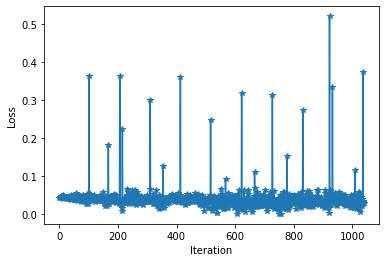

In [35]:
# RNN训练 具体的参数可以自行调整
n_hidden = 128
n_input = 50
n_output = 4
rnn = RNN(n_input, n_hidden, n_output)
rnn.to(device)
train(rnn, train_iterator, lr=0.0005, num_epoch=10)

## 四、结果评测

计算RNN模型在测试集上的准确率：

In [36]:
def eval_test(model, iterator):
    total_cnt = 0
    total_acc = 0
    
    model.eval()
    
    for batch_data in iterator:
        texts, text_lengths = batch_data.text
        labels = batch_data.label
        
        for text, label in zip(texts, labels):
            hidden = model.init_hidden().to(device)
            for i in range(len(text)):
                embedding = TEXT.vocab.vectors[text[i]]
                embedding = embedding.to(device)
                output, hidden = model(embedding.reshape(1, -1), hidden)
            
            if output.argmax(1) == label - 1:  # 判断预测概率最大的类是否正确
                total_acc += 1
            total_cnt += 1

    print("Test Acc:", total_acc / total_cnt)

**请加载效果最好的模型，输出模型在测试集上的准确率**

In [37]:
# TODO
rnn = torch.load('best.pt')
# rnn.load_state_dict(torch.load('best.pt'))
rnn.eval()
eval_test(rnn, test_iterator)

Test Acc: 0.556


## 五、附加部分（1'）

**可选1 模型优化**：在上述文本分类任务中，只使用了文章的正文内容，没有利用标题中的信息。请尝试加入标题内容，修改模型，以优化模型的分类能力。

In [38]:
# 在处理数据时增加title的部分
TEXT = data.Field(sequential=True, batch_first=True, include_lengths=True)
TITLE = data.Field(sequential=True, batch_first=True, include_lengths=True)
LABEL = data.Field(sequential=False, batch_first=True, use_vocab=False)

fields = [('label', LABEL), ('title', TITLE), ('text',TEXT)]  # 通过定义fields可以方便地读取数据，这里第一列为label，第三列为需要分类的text，标题暂时不需要

train_data = data.TabularDataset(path='train.csv', format='csv', fields=fields, skip_header=False)
test_data = data.TabularDataset(path='test.csv', format='csv', fields=fields, skip_header=False)

#initialize glove embeddings
TEXT.build_vocab(train_data, min_freq=3, vectors="glove.6B.50d")  # 去除低频词，使用50维的预训练词向量
TITLE.build_vocab(train_data, min_freq=1, vectors="glove.6B.50d")  # 去除低频词，使用50维的预训练词向量
LABEL.build_vocab(train_data)